<a href="https://colab.research.google.com/github/Nicohim87/DeepLearning-AOL/blob/main/Model2/Resnet18_Model2_parity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [2]:
import kagglehub

# Download latest version
DATASET_PATH = kagglehub.dataset_download("dionisiusdh/indonesian-batik-motifs")

print("Path to dataset files:", DATASET_PATH)

100%|██████████| 262M/262M [00:04<00:00, 63.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dionisiusdh/indonesian-batik-motifs/versions/1


In [3]:
img = tf.keras.utils.load_img(os.path.join(DATASET_PATH, 'batik-megamendung/1.jpg'), color_mode='rgb')
img = tf.keras.utils.img_to_array(img)
img.shape

(960, 1280, 3)

In [4]:
CHOSEN_CLASSNAME = ['batik-megamendung', 'batik-tambal', 'batik-parang']
INPUT_SHAPE = (224, 224)

images = []
classes = []

In [5]:
from PIL import Image, UnidentifiedImageError

In [6]:
for i, classname in enumerate(CHOSEN_CLASSNAME):
    for j, filename in enumerate(os.listdir(os.path.join(DATASET_PATH, classname))):
        try:
          img = tf.keras.utils.load_img(os.path.join(DATASET_PATH, classname, filename), color_mode='rgb', target_size=INPUT_SHAPE)
          img = tf.keras.utils.img_to_array(img)
          img = img/255
          images.append(img)
          classes.append(i)
        except UnidentifiedImageError:
          print(f"Skipping {classname}/{filename}: Img unidentified")
        except Exception as e:
          print(f"Skipping {classname}/{filename}: An error occurred - {e}")

Skipping batik-megamendung/49.jpg: Img unidentified


[]

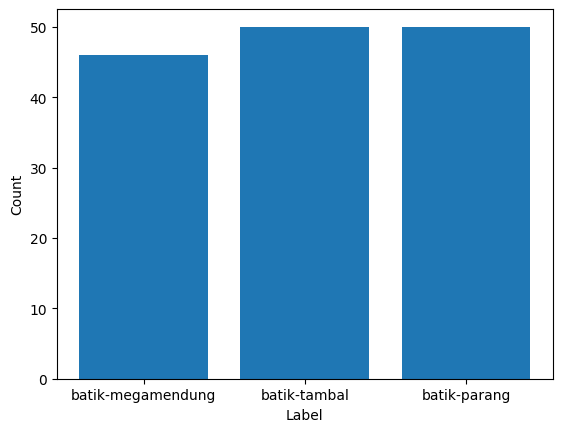

In [7]:
label, count = np.unique(classes, return_counts=True) # Menghitung jumlah kemunculan dari suatu label
# Plotting
plt.bar(label, count)
plt.ylabel("Count")
plt.xlabel("Label")
plt.xticks([0, 1, 2],CHOSEN_CLASSNAME)
plt.plot()

In [8]:
images = np.array(images)
classes = np.array(classes)

In [9]:
y = tf.keras.utils.to_categorical(classes, num_classes=len(CHOSEN_CLASSNAME))
y.shape

(146, 3)

In [10]:
images.shape

(146, 224, 224, 3)

# **Train Test Splitting**

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
x_train, x_temp, y_train, y_temp = train_test_split(images, y, train_size=0.7)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

[]

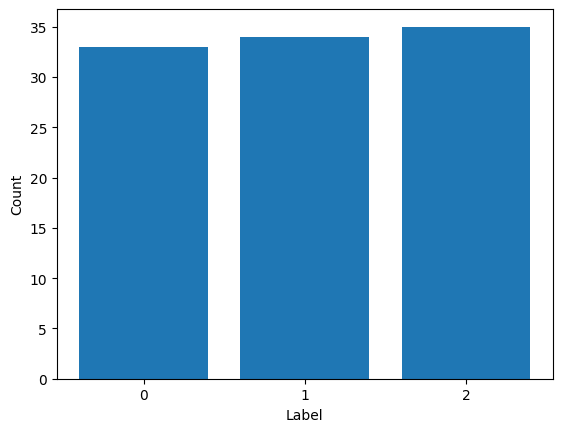

In [13]:
ylabel = [np.argmax(i) for i in y_train]

label, count = np.unique(ylabel, return_counts=True) # Menghitung jumlah kemunculan dari suatu label
# Plotting
plt.bar(label, count)
plt.ylabel("Count")
plt.xlabel("Label")
plt.xticks(label)
plt.plot()

# **Augmentation**

In [14]:
CLASS_SIZE = 50

In [15]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_flip_up_down(image)  # Random horizontal flip
    image = tf.image.random_brightness(image, max_delta=0.1)  # Random brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Random contrast
    return image, label

def generate_data(x_train, y_train, size):
    # Initial Shuffle
    permutation = np.random.permutation(len(x_train))

    x_train = x_train[permutation]
    y_train = y_train[permutation]

    # Data Generation
    permutation = np.random.permutation(size)
    permutation %= len(x_train)

    x_train_generated = []
    y_train_generated = []
    for i in permutation:
        x_gen, y_gen = augment_image(x_train[i], y_train[i])
        x_train_generated.append(x_gen)
        y_train_generated.append(y_gen)

    return x_train_generated, y_train_generated

In [16]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train_augmented = []
y_train_augmented = []
for i in range(len(CHOSEN_CLASSNAME)):
    indices = np.where(y_train[:, i] == 1)[0]

    x_aug, y_aug = generate_data(x_train[indices], y_train[indices], CLASS_SIZE)
    x_train_augmented.extend(x_aug)
    y_train_augmented.extend(y_aug)

In [17]:
x_train_augmented = np.array(x_train_augmented)
y_train_augmented = np.array(y_train_augmented)

permutation = np.random.permutation(len(x_train_augmented))

x_train_augmented = x_train_augmented[permutation]
y_train_augmented = y_train_augmented[permutation]

In [18]:
x_train_augmented.shape

(150, 224, 224, 3)

[]

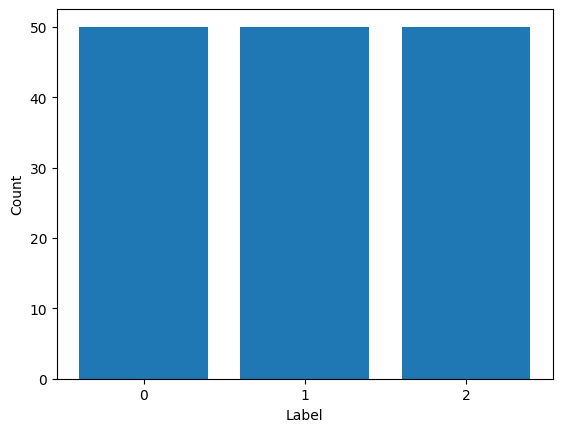

In [19]:
ylabel = [np.argmax(i) for i in y_train_augmented]

label, count = np.unique(ylabel, return_counts=True) # Menghitung jumlah kemunculan dari suatu label
# Plotting
plt.bar(label, count)
plt.ylabel("Count")
plt.xlabel("Label")
plt.xticks(label)
plt.plot()

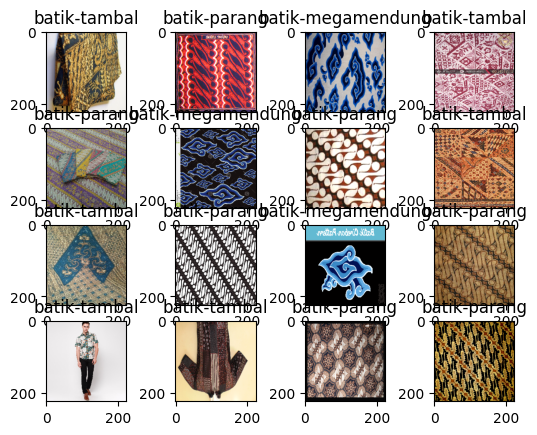

In [20]:
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train_augmented[i], cmap='gray')
    plt.title(CHOSEN_CLASSNAME[np.argmax(y_train_augmented[i])])

# **Model**

In [21]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import Add, GlobalAveragePooling2D, Dense, Activation

In [22]:
EPOCHS = 20
BATCH_SIZE = 25
LEARNING_RATE = 1e-4

In [23]:

def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False):
    shortcut = x

    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride, padding='valid')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)

    return x

def ResNet18(input_tensor, classes):
    # Initial layers
    x = Conv2D(64, 7, strides=2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    # ResNet blocks
    x = residual_block(x, 64, conv_shortcut=True)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2, conv_shortcut=True)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2, conv_shortcut=True)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2, conv_shortcut=True)
    x = residual_block(x, 512)

    return tf.keras.Model(inputs=input_tensor, outputs=x)

# Usage example:
def create_model(input_shape, num_classes):
    input = Input(shape=input_shape)
    base_model = ResNet18(input, classes=num_classes)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    return model

In [24]:
model= model = create_model(x_train_augmented[0].shape, len(CHOSEN_CLASSNAME))

optimizer = Adam(learning_rate = LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 56, 56, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 11,261,379 (42.96 MB)

 Trainable params: 11,251,651 (42.92 MB)

 Non-trainable params: 9,728 (38.00 KB)

In [25]:
hist = model.fit(x_train_augmented, y_train_augmented, validation_data = (x_val, y_val), epochs = EPOCHS, batch_size = BATCH_SIZE)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 745ms/step - accuracy: 0.5030 - loss: 1.4383 - val_accuracy: 0.4091 - val_loss: 1.0884
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.6885 - loss: 0.7168 - val_accuracy: 0.4545 - val_loss: 1.0613
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9226 - loss: 0.2463 - val_accuracy: 0.4545 - val_loss: 1.0522
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9589 - loss: 0.1402 - val_accuracy: 0.4545 - val_loss: 1.0765
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9656 - loss: 0.1287 - val_accuracy: 0.4545 - val_loss: 1.1377
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 1.0000 - loss: 0.0435 - val_accuracy: 0.4545 - val_loss: 1.2796
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9723 - loss: 0.0566 - val_accuracy: 0.4545 - val_loss: 1.4347
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9908 - loss: 0.0267 - val_accuracy: 0.4545 - val_loss: 1.7

# **Evaluation**

In [26]:
from sklearn import metrics

In [27]:
loss, accuracy = model.evaluate(x_test, y_test, verbose = 1)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2727 - loss: 4.3104
Loss: 4.310428142547607
Accuracy: 0.27272728085517883


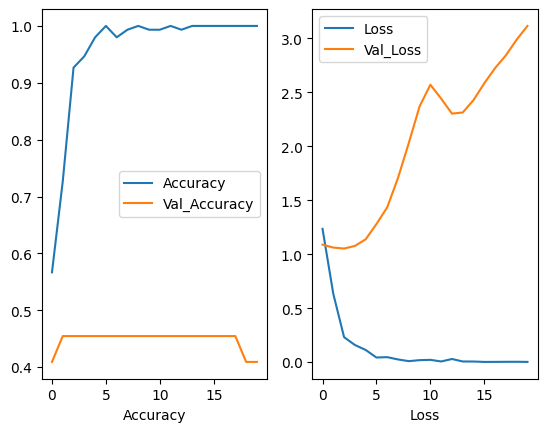

In [28]:
# Accuracy
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('Epochs')
plt.xlabel('Accuracy')
plt.legend(['Accuracy', "Val_Accuracy"])

# Loss
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epochs')
plt.xlabel('Loss')
plt.legend(['Loss', "Val_Loss"])

# Tampilkan Plot
plt.show()

In [29]:
pred = model.predict(x_test) # Flatten untuk memastikan bahwa output hanya berupa 1D array

pred = [CHOSEN_CLASSNAME[np.argmax(i)] for i in pred] # Mendecode hasil prediksi nya, index perlu di bulatkan karena fungsi sigmoid normalnya tidak menghasilkan bilangan bulat
actual = [CHOSEN_CLASSNAME[np.argmax(i)] for i in y_test] # Mendecode nilai asli nya

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


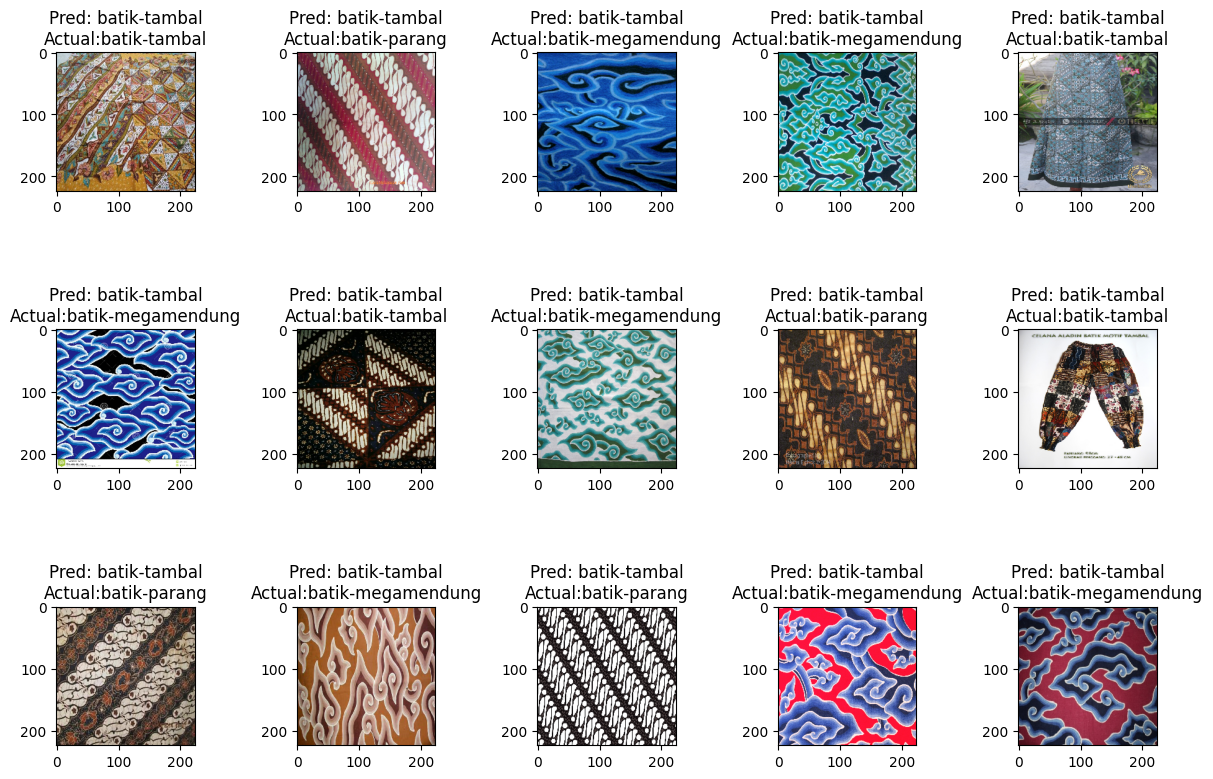

In [30]:
plt.figure(figsize=(15,9)) # Menentukan ukuran plot
for i in range(15):
    plt.subplot(3, 5, i+1) # Menentukan lokasi subplot nya
    plt.imshow(x_test[i], cmap='gray') # Menampilkan gambar

    plt.title(f"Pred: {pred[i]}\nActual:{actual[i]}") # Menampilkan actual value dan prediction nya

plt.subplots_adjust(hspace=1)

In [31]:
print(metrics.classification_report(pred, actual))

                   precision    recall  f1-score   support

batik-megamendung       0.00      0.00      0.00         0
     batik-parang       0.00      0.00      0.00         0
     batik-tambal       1.00      0.27      0.43        22

         accuracy                           0.27        22
        macro avg       0.33      0.09      0.14        22
     weighted avg       1.00      0.27      0.43        22



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


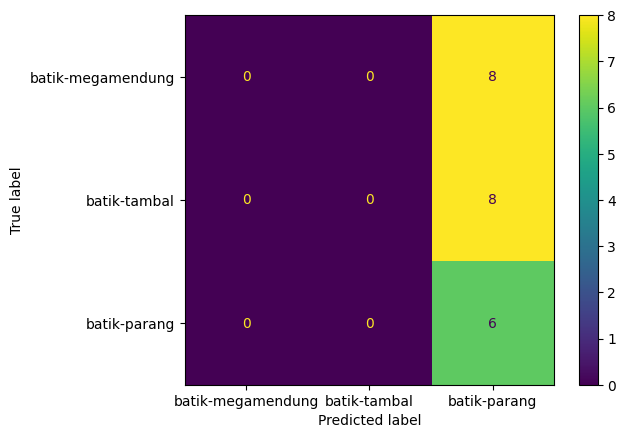

In [32]:
CM = metrics.confusion_matrix(actual, pred) # Membuat confusion matrix nya
fig = metrics.ConfusionMatrixDisplay(CM, display_labels=CHOSEN_CLASSNAME) # Display labels agar label yang ditunjukan sudah di decode
fig.plot() # Plot confusion matrix nya